In [109]:
%matplotlib inline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn

import matplotlib.pyplot as plt
from sklearn import preprocessing, linear_model
from tools import gen_linear, display_graph,display_tab, plot_data, gen_arti, plot_frontiere

In [110]:
dataA_train = pd.read_csv('data/classificationA.train', sep='\t', header=None)
dataB_train = pd.read_csv('data/classificationB.train', sep='\t', header=None)
dataC_train = pd.read_csv('data/classificationC.train', sep='\t', header=None)

dataA_test = pd.read_csv('data/classificationA.test', sep='\t', header=None)
dataB_test = pd.read_csv('data/classificationB.test', sep='\t', header=None)
dataC_test = pd.read_csv('data/classificationC.test', sep='\t', header=None)

In [111]:
XA_train, yA_train = dataA_train.values[:,0:2], dataA_train.values[:,2]
XB_train, yB_train = dataB_train.values[:,0:2], dataB_train.values[:,2]
XC_train, yC_train = dataC_train.values[:,0:2], dataC_train.values[:,2]

XA_test, yA_test = dataA_test.values[:,0:2], dataA_test.values[:,2]
XB_test, yB_test = dataB_test.values[:,0:2], dataB_test.values[:,2]
XC_test, yC_test = dataC_test.values[:,0:2], dataC_test.values[:,2]
                                                                   

Text(0.5, 1.0, 'Test C')

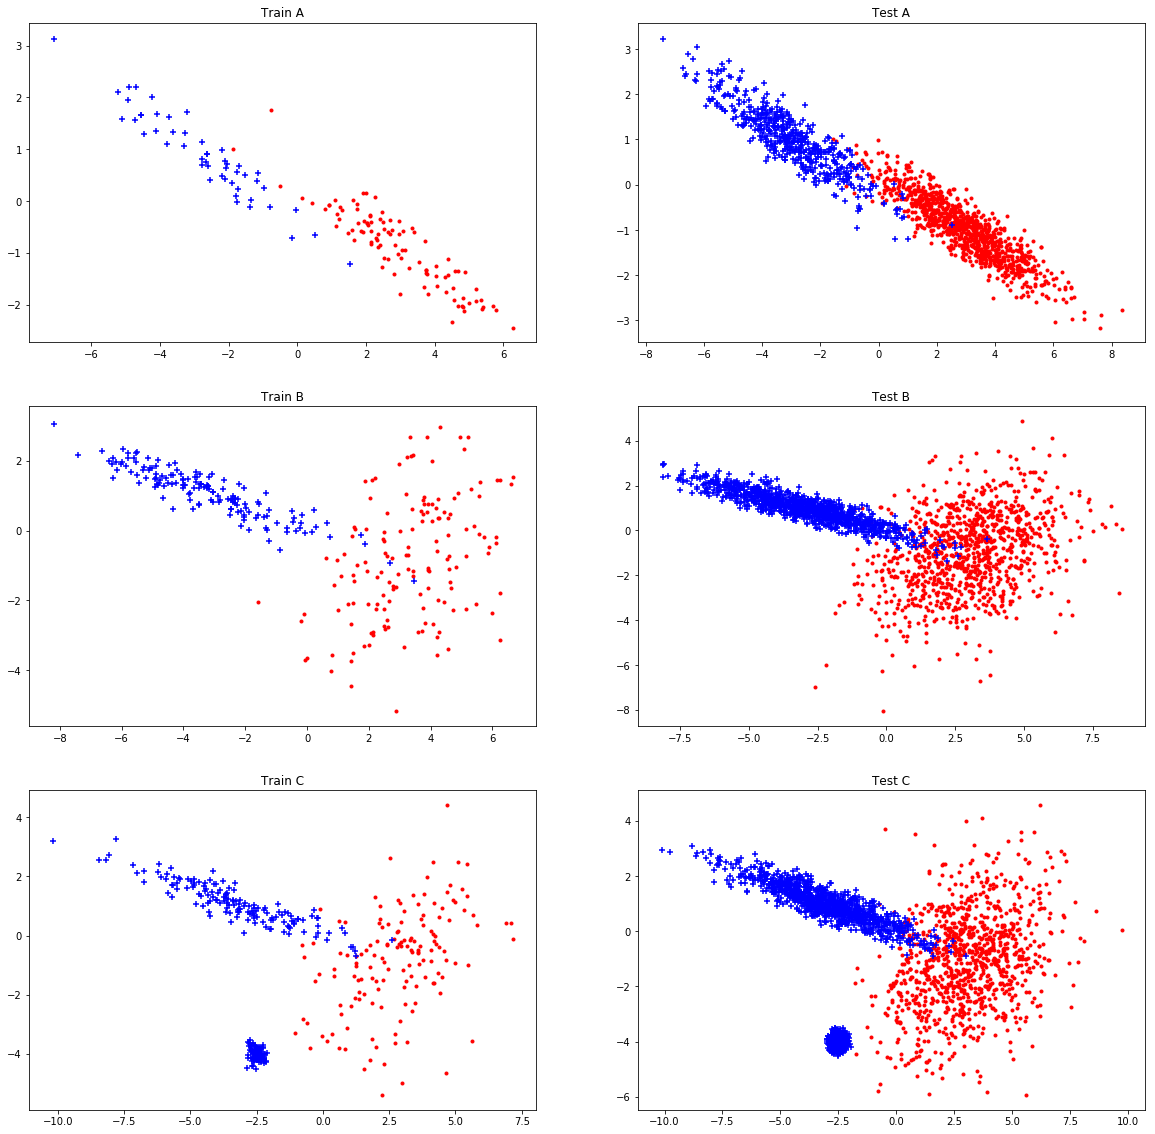

In [112]:
### Donnees artificielles, essais sur la variance des gaussiennes
plt.figure(figsize=(20,20))

plt.subplot(3,2,1)
plot_data(XA_train,yA_train)
plt.title('Train A')

plt.subplot(3,2,2)
plot_data(XA_test,yA_test)
plt.title('Test A')

plt.subplot(3,2,3)
plot_data(XB_train,yB_train)
plt.title('Train B')

plt.subplot(3,2,4)
plot_data(XB_test,yB_test)
plt.title('Test B')

plt.subplot(3,2,5)
plot_data(XC_train,yC_train)
plt.title('Train C')

plt.subplot(3,2,6)
plot_data(XC_test,yC_test)
plt.title('Test C')

In [113]:
class Model():
    def misclassification_error(self,X,y):
        y_pred = self.predict(X)
        return np.sum(y_pred!=y)/y.shape[0]
    
    def plot_data_frontiere(self,X,y,c=0.01,step=1000):
        plt.figure(figsize=(10,10))
        self.fit(X,y)
        plot_data(X,y)
        plot_frontiere(X, self.predict, step, alpha_c=0.1)
        plt.title(self.model_name)
        

# Generative Model(LDA)

In [114]:
class LDA(Model):
    model_name = 'LDA'
    def fit(self,X,y):
        n = y.shape[0]
        Ny = np.sum(y==0)
        
        pi = Ny/n
        
        mu0 = np.sum(X[y==0],axis=0)/(Ny)
        mu1 = np.sum(X[y==1],axis=0)/(n-Ny)
        
        sigma = ((X[y==0]-mu0).T.dot((X[y==0]-mu0))+(X[y==1]-mu1).T.dot((X[y==1]-mu1)))/n
        
        self.mu0 = mu0
        self.mu1 = mu1
        self.sigma = sigma
        self.pi = pi
        self.sigma_inv = np.linalg.inv(self.sigma)
        
    def predict_proba(self,X):
        
        if X.ndim != 1:
            p1 = self.pi*np.exp(np.apply_along_axis(lambda x:-0.5*(x-self.mu1).dot(self.sigma_inv).dot((x-self.mu1).T), arr=X, axis=1))
            p0 = (1-self.pi)*np.exp(np.apply_along_axis(lambda x:-0.5*(x-self.mu0).dot(self.sigma_inv).dot((x-self.mu0).T), arr=X, axis=1))
            p1 = p1/(p0+p1)
        else:
            p1 = self.pi*np.exp(-0.5*(X-self.mu1).dot(self.sigma_inv).dot((X-self.mu1).T))
            p0 = (1-self.pi)*np.exp(-0.5*(X-self.mu0).dot(self.sigma_inv).dot((X-self.mu0).T))
            p1 = p1/(p0+p1)
        
        return p1

    def predict(self,X):
        return self.predict_proba(X)>0.5


In [115]:
lda = LDA()

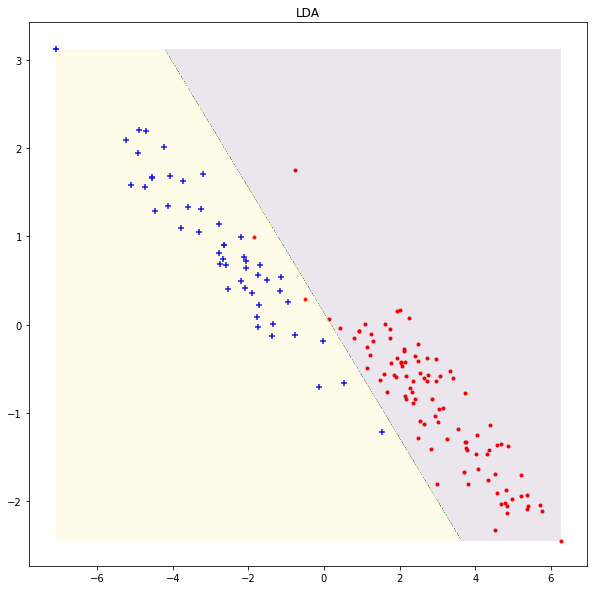

In [116]:
lda.plot_data_frontiere(XA_train, yA_train)

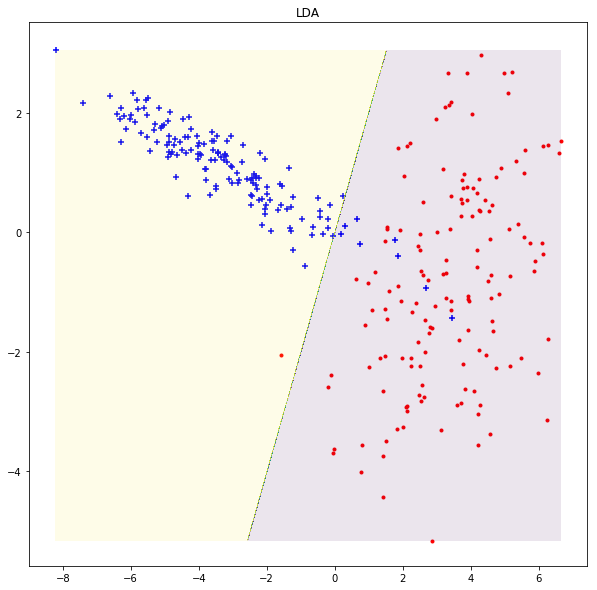

In [117]:
lda.plot_data_frontiere(XB_train, yB_train)

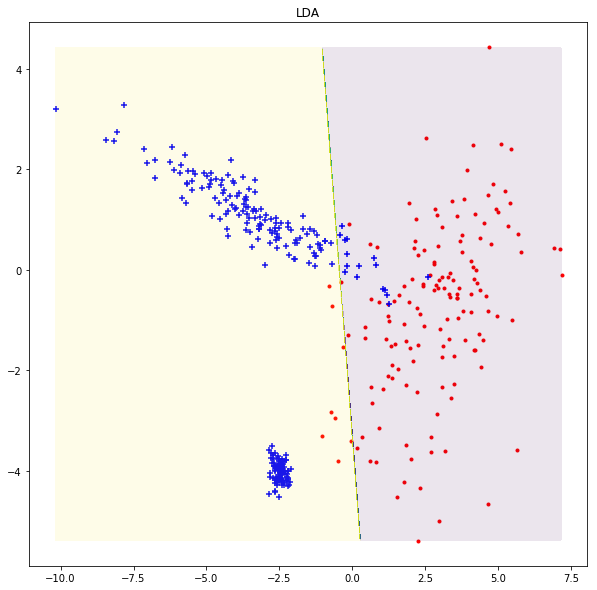

In [118]:
lda.plot_data_frontiere(XC_train, yC_train)

In [119]:
lda.fit(XA_train, yA_train)
misclass_Atrain = lda.misclassification_error(XA_train, yA_train)
misclass_Atest = lda.misclassification_error(XA_test, yA_test)

lda.fit(XB_train, yB_train)
misclass_Btrain = lda.misclassification_error(XB_train, yB_train)
misclass_Btest = lda.misclassification_error(XB_test, yB_test)

lda.fit(XC_train, yC_train)
misclass_Ctrain = lda.misclassification_error(XC_train, yC_train)
misclass_Ctest = lda.misclassification_error(XC_test, yC_test)

In [120]:
print(misclass_Atrain, misclass_Atest)
print(misclass_Btrain, misclass_Btest)
print(misclass_Ctrain, misclass_Ctest)

0.013333333333333334 0.032
0.03 0.0415
0.06 0.044


# Logisitic regression

In [121]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [122]:
class LogisticRegression(Model):
    model_name = 'Logistic regression'
    
    def fit(self, X, Y, eps=1e-5):
        offset = np.ones(X.shape[0])
        offset = offset.reshape(-1,1)
        X = np.hstack((offset, X))
        
        p = X.shape[1]
        w = np.zeros(p)
        
        convergence = False
        while not(convergence):
            eta = sigmoid(X.dot(w))
            grad_w = np.dot(X.T, Y - eta)
            h_w = - X.T.dot(np.diag(eta * (1 - eta))).dot(X)
            
            convergence = (- grad_w.T.dot(np.linalg.inv(h_w)).dot(grad_w) / 2 < eps)
            if(convergence):
                break
            else:
                w = w - np.dot(np.linalg.inv(h_w), grad_w)
            
        self.w = w
        return w

    def predict_proba(self, X):
        #we add a colon of ones for the offset
        offset = np.ones(X.shape[0])
        offset=offset.reshape(-1,1)
        X=np.hstack((offset,X))
        #We check the matrix dimensions to be compatible
        assert(X.shape[-1]==self.w.shape[0])
        
        return sigmoid(np.dot(X, self.w))
        
    def predict(self,X):
        return self.predict_proba(X) > 0.5

In [123]:
logreg= LogisticRegression()

In [124]:
w = np.random.random(2)
eta = sigmoid(XC_train.dot(w))
grad_w = - np.dot(XC_train.T, yC_train - eta)
h_w = - np.dot(np.dot(XC_train.T, np.diag(eta * (1 - eta))), XC_train)

In [125]:
logreg.fit(XA_train, yA_train)
misclass_Atrain = logreg.misclassification_error(XA_train, yA_train)
misclass_Atest = logreg.misclassification_error(XA_test, yA_test)

logreg.fit(XB_train, yB_train)
misclass_Btrain = logreg.misclassification_error(XB_train, yB_train)
misclass_Btest = logreg.misclassification_error(XB_test, yB_test)

logreg.fit(XC_train, yC_train)
misclass_Ctrain = logreg.misclassification_error(XC_train, yC_train)
misclass_ctest = logreg.misclassification_error(XC_test, yC_test)

/home/leo-alberge/.local/share/virtualenvs/TP1-jTALiYWQ/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [126]:
print(misclass_Atrain, misclass_Atest)
print(misclass_Btrain, misclass_Btest)
print(misclass_Ctrain, misclass_Ctest)

0.0 0.034
0.02 0.043
0.04 0.044


# Linear Regression

In [127]:
class LinearRegression(Model):
    model_name = 'Linear Regression'
    def fit(self,X,Y):
        offset = np.ones(X.shape[0])
        offset=offset.reshape(-1,1)
        X=np.hstack((offset,X))
        w =  np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y) 
        self.w = w 
        return w

    def predict_proba(self,X, w=None):
        if w is None:
            w = self.w
        #we add a colon of ones for the offset
        offset = np.ones(X.shape[0])
        offset=offset.reshape(-1,1)
        X=np.hstack((offset,X))
        #We check the matrix dimensions to be compatible
        assert(X.shape[-1]==w.shape[0])

        return X.dot(w)

    def predict(self,X, w=None):
        if w is None:
            w = self.w
        return self.predict_proba(X,w)>0.5


In [128]:
lin = LinearRegression()

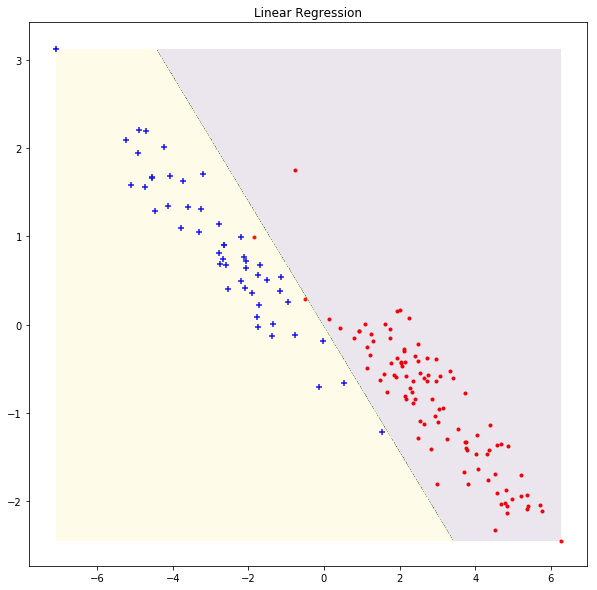

In [129]:
lin.plot_data_frontiere(XA_train, yA_train)

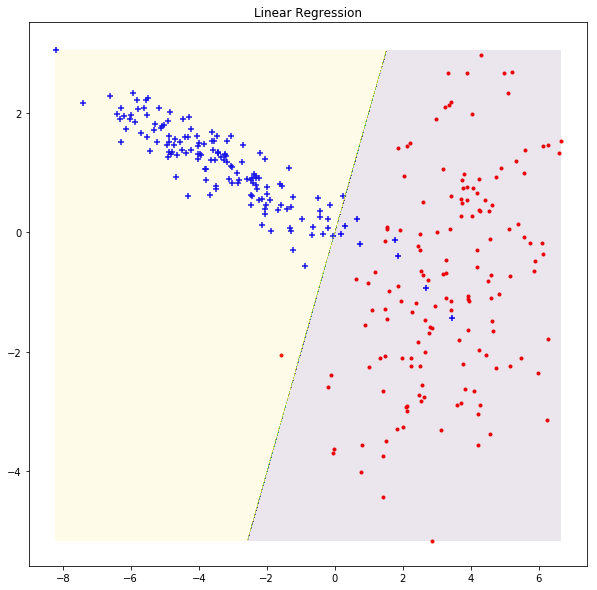

In [130]:
lin.plot_data_frontiere(XB_train, yB_train)

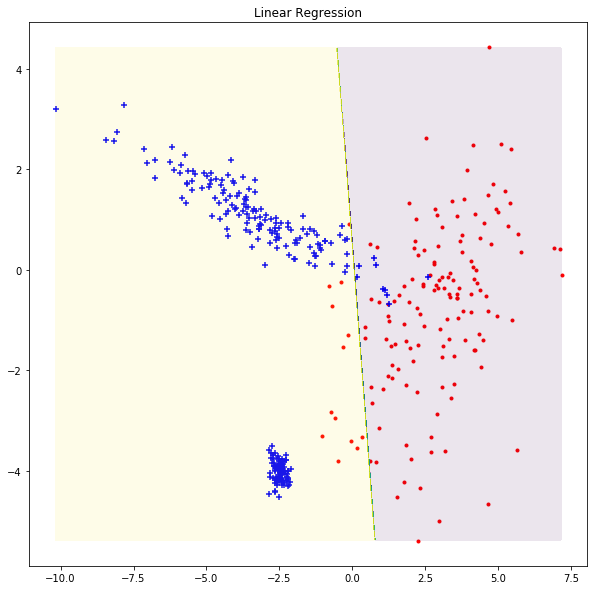

In [131]:
lin.plot_data_frontiere(XC_train, yC_train)

In [132]:
lin.fit(XA_train, yA_train)
misclass_Atrain = lda.misclassification_error(XA_train, yA_train)
misclass_Atest = lda.misclassification_error(XA_test, yA_test)

lin.fit(XB_train, yB_train)
misclass_Btrain = lda.misclassification_error(XB_train, yB_train)
misclass_Btest = lda.misclassification_error(XB_test, yB_test)

lin.fit(XC_train, yC_train)
misclass_Ctrain = lda.misclassification_error(XC_train, yC_train)
misclass_Ctest = lda.misclassification_error(XC_test, yC_test)

In [133]:
print(misclass_Atrain, misclass_Atest)
print(misclass_Btrain, misclass_Btest)
print(misclass_Ctrain, misclass_Ctest)

0.04666666666666667 0.022
0.07 0.0715
0.06 0.044


# QDA 

In [134]:
class QDA(Model):
    model_name = 'QDA'
    def fit(self,X,y):
        n = y.shape[0]
        Ny = np.sum(y==0)
        
        pi = Ny/n
        
        mu0 = np.sum(X[y==0],axis=0)/(Ny)
        mu1 = np.sum(X[y==1],axis=0)/(n-Ny)
        
        sigma_0 = (X[y==0]-mu0).T.dot((X[y==0]-mu0))
        sigma_1 = (X[y==1]-mu1).T.dot((X[y==1]-mu1))
        
        self.mu0 = mu0
        self.mu1 = mu1
        
        self.sigma_0 = sigma_0/(n*Ny)
        self.sigma_1 = sigma_1/((n-Ny)*Ny)   
        self.pi = pi
        
        self.sigma0_inv = np.linalg.inv(self.sigma_0)
        self.sigma1_inv = np.linalg.inv(self.sigma_1)
        
        self.sigma0_det = np.linalg.det(self.sigma_0)
        self.sigma1_det = np.linalg.det(self.sigma_1)
        
    def predict_proba(self,X):
        
        if X.ndim != 1:
            p1 = self.pi/self.sigma1_det*np.exp(np.apply_along_axis(lambda x:-0.5*(x-self.mu1).dot(self.sigma1_inv).dot((x-self.mu1).T), arr=X, axis=1))
            p0 = (1-self.pi)/self.sigma0_det*np.exp(np.apply_along_axis(lambda x:-0.5*(x-self.mu0).dot(self.sigma0_inv).dot((x-self.mu0).T), arr=X, axis=1))
            p1 = p1/(p0+p1)
        else:
            p1 = self.pi/self.sigma1_det*np.exp(-0.5*(X-self.mu1).dot(self.sigma1_inv).dot((X-self.mu1).T))
            p0 = (1-self.pi)/self.sigma0_det*np.exp(-0.5*(X-self.mu0).dot(self.sigma0_inv).dot((X-self.mu0).T))
            p1 = p1/(p0+p1)
        
        return p1

    def predict(self,X):
        return self.predict_proba(X)>0.5


In [137]:
qad = QDA()

/home/leo-alberge/.local/share/virtualenvs/TP1-jTALiYWQ/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/leo-alberge/.local/share/virtualenvs/TP1-jTALiYWQ/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


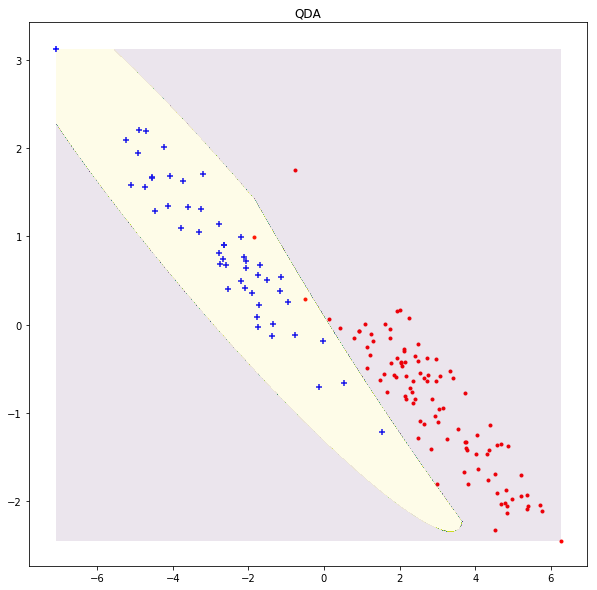

In [138]:
qad.plot_data_frontiere(XA_train, yA_train)

/home/leo-alberge/.local/share/virtualenvs/TP1-jTALiYWQ/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/leo-alberge/.local/share/virtualenvs/TP1-jTALiYWQ/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


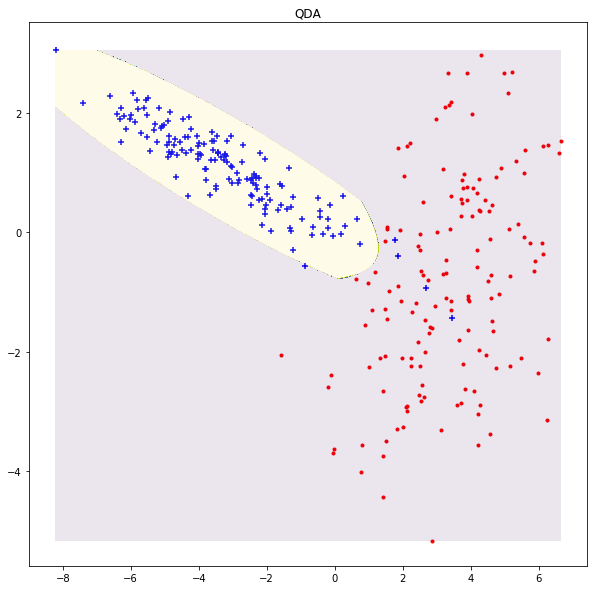

In [139]:
qad.plot_data_frontiere(XB_train, yB_train)

/home/leo-alberge/.local/share/virtualenvs/TP1-jTALiYWQ/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/leo-alberge/.local/share/virtualenvs/TP1-jTALiYWQ/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


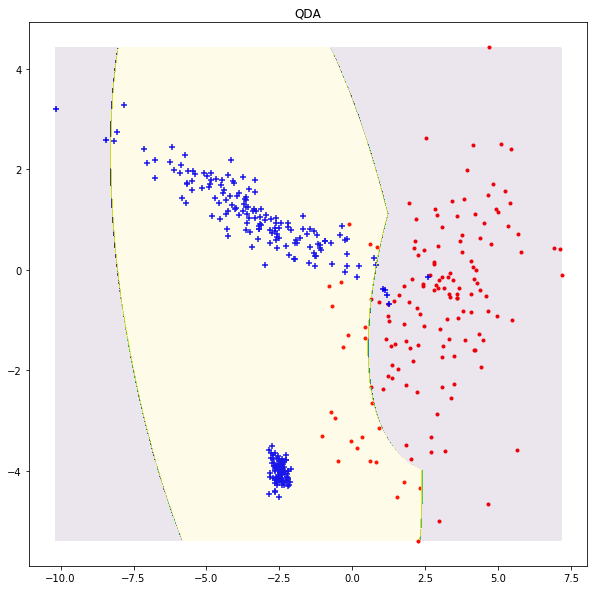

In [140]:
qad.plot_data_frontiere(XC_train, yC_train)

In [141]:
qad.fit(XA_train, yA_train)
misclass_Atrain = qad.misclassification_error(XA_train, yA_train)
misclass_Atest = qad.misclassification_error(XA_test, yA_test)

qad.fit(XB_train, yB_train)
misclass_Btrain = qad.misclassification_error(XB_train, yB_train)
misclass_Btest = qad.misclassification_error(XB_test, yB_test)

qad.fit(XC_train, yC_train)
misclass_Ctrain = qad.misclassification_error(XC_train, yC_train)
misclass_Ctest = qad.misclassification_error(XC_test, yC_test)

/home/leo-alberge/.local/share/virtualenvs/TP1-jTALiYWQ/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/leo-alberge/.local/share/virtualenvs/TP1-jTALiYWQ/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


In [142]:
print(misclass_Atrain, misclass_Atest)
print(misclass_Btrain, misclass_Btest)
print(misclass_Ctrain, misclass_Ctest)

0.013333333333333334 0.028666666666666667
0.016666666666666666 0.0195
0.08 0.055
